In [1]:
import import_ipynb
import torch
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from GEN_AR_DATA import *
import matplotlib.pyplot as plt

importing Jupyter notebook from GEN_AR_DATA.ipynb


In [2]:
#####################
# Set parameters
#####################

# Data params
noise_var = 0
num_datapoints = 7103
test_size = 0.2
num_train = int((1-test_size) * num_datapoints)

# Network params
input_size = 20
# If `per_element` is True, then LSTM reads in one timestep at a time.
per_element = True
if per_element:
    lstm_input_size = 1
else:
    lstm_input_size = input_size
# size of hidden layers
h1 = 32
output_dim = 1
num_layers = 2
learning_rate = 1e-3
num_epochs = 500
dtype = torch.float

In [8]:
#####################
# Generate data
#####################
#f=open('Computer2Node49')
#data=[]
data = ARData(num_datapoints, num_prev=input_size, test_size=test_size, noise_var=noise_var, coeffs=fixed_ar_coefficients[input_size])

# make training and test sets in torch
X_train = torch.from_numpy(data.X_train).type(torch.Tensor)
X_test = torch.from_numpy(data.X_test).type(torch.Tensor)


y_train = torch.from_numpy(data.y_train).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(data.y_test).type(torch.Tensor).view(-1)
print(data.y_test)
print("yell")
print(data.X_test)
#print(data.y_train)
X_train = X_train.view([input_size, -1, 1])
X_test = X_test.view([input_size, -1, 1])

[-4.39361634e-24  9.55775965e-25  6.09221413e-24 ... -2.22536166e-29
 -3.18988197e-29 -3.74667095e-29]
yell
[[-1.61419305e-23 -1.19786725e-23 -6.42558701e-24 ... -1.53864261e-23
  -1.31222251e-23 -9.29254757e-24]
 [-1.19786725e-23 -6.42558701e-24 -1.86956024e-25 ... -1.31222251e-23
  -9.29254757e-24 -4.39361634e-24]
 [-6.42558701e-24 -1.86956024e-25  5.96231212e-24 ... -9.29254757e-24
  -4.39361634e-24  9.55775965e-25]
 ...
 [ 8.58872258e-30 -8.00202479e-30 -2.33144290e-29 ...  1.81125751e-29
   4.37077942e-30 -9.65857495e-30]
 [-8.00202479e-30 -2.33144290e-29 -3.54975216e-29 ...  4.37077942e-30
  -9.65857495e-30 -2.22536166e-29]
 [-2.33144290e-29 -3.54975216e-29 -4.31168878e-29 ... -9.65857495e-30
  -2.22536166e-29 -3.18988197e-29]]


In [ ]:
#####################
# Build model
#####################

# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=False)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
#####################
# Train model
#####################

hist = np.zeros(num_epochs)

for t in tqdm(range(num_epochs)):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

[[-0.11692404 -0.21328788  0.50147988 ...  0.105994   -0.02618355
  -0.01559618]
 [-0.21328788  0.50147988  0.44307357 ... -0.02618355 -0.01559618
  -0.06285747]
 [ 0.50147988  0.44307357 -0.03943261 ... -0.01559618 -0.06285747
  -0.11467017]
 ...
 [ 0.19082056  0.00817218  0.02808303 ...  0.00747364  0.02972803
   0.09385467]
 [ 0.00817218  0.02808303 -0.01641302 ...  0.02972803  0.09385467
   0.1315326 ]
 [ 0.02808303 -0.01641302 -0.05961602 ...  0.09385467  0.1315326
   0.12199914]]
20


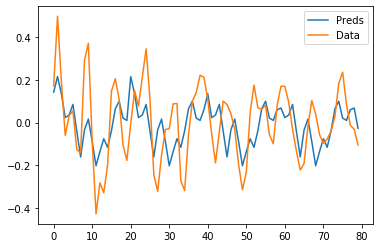

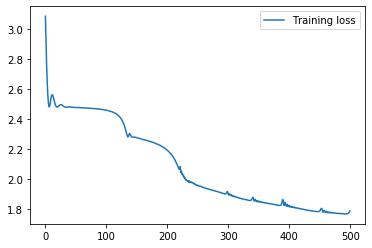

In [9]:
#####################
# Plot preds and performance
#####################

plt.plot(y_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()